# Step 1. 準備訓練資料

In [1]:
from sklearn import datasets
from sklearn.model_selection import train_test_split

circles_data, circles_data_labels = datasets.make_circles(n_samples=100, factor=0.1, noise=0.1)

px_data_0 = list()
py_data_0 = list()
px_data_1 = list()
py_data_1 = list()

for (x, y), t in zip(circles_data, circles_data_labels):
    if t==1:
        px_data_1.append(x)
        py_data_1.append(y)
    else:
        px_data_0.append(x)
        py_data_0.append(y)

# 分割 70% 訓練集，30% 測試集
x_train, x_test, y_train, y_test = train_test_split(
    circles_data, circles_data_labels, train_size=0.7, random_state=42)

# Step 2. 建立神經網路

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

class FullyConnect(nn.Module):
    def __init__(self, in_size,
                       out_size,
                       activation=None):
        super().__init__()
        self.linear = nn.Linear(in_size, out_size)
        self.act = activation

    def forward(self, x):
        x = self.linear(x)
        if self.act is not None:
            x = self.act(x)
        return x

class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)

class Network(nn.Module):
    def __init__(self, mid):
        super().__init__()
        self.layers = nn.Sequential(
          FullyConnect(2, mid),
          Swish(),
          FullyConnect(mid, mid),
          Swish(),
          FullyConnect(mid, 2)
        )
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.layers(x)
        return x

    def get_max(self, x):
        x_tensor = torch.from_numpy(x).float()
        y = self(x_tensor)
        y = self.softmax(y)
        _, i = torch.max(y, 1)
        return i.detach().cpu().numpy()

    def get_maxprob(self, x):
        x_tensor = torch.from_numpy(x).float()
        y = self(x_tensor)
        y = self.softmax(y)
        v, i = torch.max(y, 1)
        out = torch.where(i == 0, 1. - v, v)
        return out.detach().cpu().numpy()

net = Network(32)

# Step 3. 訓練網路

In [3]:
opt = optim.SGD(net.parameters(),
                lr=0.2,
                momentum=0.9,
                nesterov=True,
                weight_decay=0.)

def loss_fn(pred, tgt):
    fn = nn.CrossEntropyLoss()
    return fn(pred, tgt)

# 訓練網路
epoches = 2000
for e in range(epoches):
    x_train_torch = torch.from_numpy(x_train).float()
    y_train_torch = torch.from_numpy(y_train).long()

    y_pred = net(x_train_torch)
    loss = loss_fn(y_pred, y_train_torch)

    opt.zero_grad()
    loss.backward()
    opt.step()

    if (e+1) % 10 == 0:
        net.eval()
        y_test_pred = net.get_max(x_test)
        result = np.where(y_test_pred == y_test, 1, 0)
        acc = result.sum()/len(result)
        print("Epoches {} -> loss: {:.4f} | accuracy : {:.2f}%".format(
                  e+1, loss.item(), 100.0 * acc))
        net.train()
        if acc >= 1.0 and loss < 0.001:
            break

Epoches 10 -> loss: 0.6787 | accuracy : 30.00%
Epoches 20 -> loss: 0.6418 | accuracy : 46.67%
Epoches 30 -> loss: 0.5285 | accuracy : 66.67%
Epoches 40 -> loss: 0.1155 | accuracy : 100.00%
Epoches 50 -> loss: 0.0019 | accuracy : 100.00%
Epoches 60 -> loss: 0.0002 | accuracy : 100.00%


# Step 4. 繪出結果

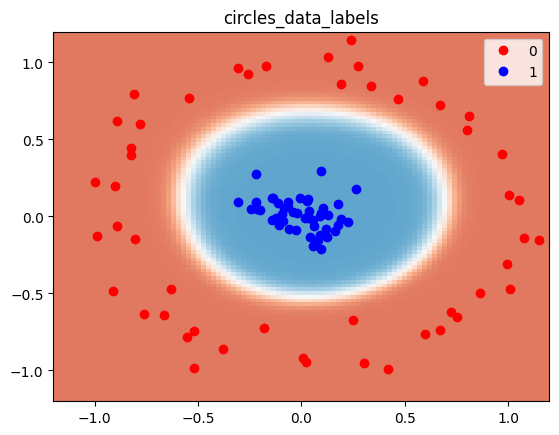

In [4]:
import matplotlib.pyplot as plt

bound = 1.20
N = 100
y, x = np.meshgrid(np.linspace(-bound, bound, N), np.linspace(-bound, bound, N))
z = np.zeros((N, N))

for i in range(N):
    for j in range(N):
        data = np.array([[x[j][i], y[j][i]]])
        z[j][i] = net.get_maxprob(data)[0]

coffset = 0.45

c = plt.pcolormesh(x, y, z, cmap='RdBu', vmin=0. - coffset, vmax=1. + coffset)
plt.title("data")
plt.axis([x.min(), x.max(), y.min(), y.max()])
plt.plot(px_data_0, py_data_0, 'o', color='red', label='0')
plt.plot(px_data_1, py_data_1, 'o', color='blue', label='1')
plt.title("circles_data_labels")
plt.legend()
plt.show()